In [1]:
import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
%matplotlib inline

In [2]:
DATA_LOCATION = '../data/'
TRAIN_IMAGES_LOCATION = '../data/train_images/'
IMAGE_SIZE = 128

In [3]:
train_labels = pd.read_csv(DATA_LOCATION + 'train_onelabel.csv')
train_labels = train_labels.rename(columns={'image': 'filepath'})

In [4]:
def get_image(row):
    """
    Load image from filepath to a numpy.ndarray
    input:
        - filepath: string with relative or absolute path to image
    output:
        - img:
            numpy.ndarray containing the image
            shaped (M,N), values [0.0, 1.0]
    """
    try:
        img = TRAIN_IMAGES_LOCATION + row['filepath']
        img = mpimg.imread(img)
    except:
        img = row
        img = mpimg.imread(img)
    img = np.absolute(np.divide(img.astype(float), 255) - 1.0)
    return img

def get_padding(i):
    """
    Helper function for getting right padding sizes
    input:
        - i: positive integer gotten from substracting height and width of an image
    output:
        - Tuple representing the correct padding
    """
    if i%2 == 0:
        return (int(i/2),int(i/2))
    else:
        return (int(i/2-.5), int(i/2+.5))
    
def pad_image(img):
    """
    Add padding to image to make it square
    input:
        - img: numpy array (2D) representing image
    output:
        - padded array of shape (N,N)
    """
    H, W = img.shape
    if H == W:
        return img
    elif H > W:
        return np.pad(img, ((0,0), get_padding(H-W)), 'constant')
    else:
        return np.pad(img, (get_padding(W-H), (0,0)), 'constant')
    
def resize_image(img, size):
    """
    Resize image to new square shape
    input:
        - img: numpy array (2D) representing image
        - size: final shape of image in pixels (integer)
    """
    return resize(img, (size,size), mode='reflect')

def flattened_image(row):
    """
    Loads and processes image to be used later on
    input:
        - row: Pandas.DataFrame row
    output:
        - Python list, flattened np.ndarray
    """
    img = get_image(row)
    img = pad_image(img)
    img = resize_image(img, IMAGE_SIZE)
    return img.flatten().tolist()

def get_shape(row):
    """
    Loads and processes image to be used later on
    input:
        - row: Pandas.DataFrame row
    output:
        - tuple, with original image dimensions
    """
    img = get_image(row)
    return img.shape

In [5]:
# get image from file
# pad the image to a sqaure
# resize to IMAGE_SIZE
# flatten and convert np.array to Python list
train_labels['image'] = train_labels.apply(flattened_image, axis=1)

# get original shape, just in case
# not really needed, so commented out
# train_labels['original_shape'] = train_labels.apply(get_shape, axis=1)

# and do we need train_labels['filepath']?
# could be dropped

In [6]:
train_labels.sample(n=10)

,filepath,class,image
20639,20206.jpg,101,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13953,139763.jpg,62,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13147,26648.jpg,58,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22769,57082.jpg,113,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1263,89071.jpg,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
23956,31291.jpg,119,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1232,45270.jpg,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1838,14.jpg,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4618,57662.jpg,21,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5790,97838.jpg,26,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


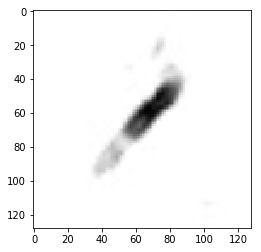

In [7]:
example = train_labels.sample(n=1).iloc[0]['image']
plt.imshow(np.asarray(example).reshape(IMAGE_SIZE,IMAGE_SIZE),cmap='binary')

In [8]:
# this creates a 4GB csv file, not really preferable
# train_labels.to_csv('~/train_labels.csv', sep='\t', encoding='utf-8')

# in terms of the template.ipynb it a different 'preprocess' approach might be useful